In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils


import matplotlib.pyplot as plt
import numpy as np
import random
import math

import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [3]:
import os
import torch
import utils
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [4]:
class Q(nn.Module):
  def __init__(self):
    super(Q,self).__init__()
    self.projection_z = fc_bn_layer(latent_dim,s_h16*s_w16*gf_dim*8)

    self.theta_params = nn.Sequential(
    tconv_bn_layer(gf_dim*8,gf_dim*4,4,stride=2,padding=1),
    nn.ReLU(),
    tconv_bn_layer(gf_dim*4,gf_dim*2,4,stride=2,padding=1),
    nn.ReLU(),
    tconv_bn_layer(gf_dim*2,gf_dim,4,stride=2,padding=1),
    nn.ReLU(),
    tconv_layer(gf_dim,c_dim,4,stride=2,padding=1),
    nn.Tanh()
    )
    
  def forward(self, x):
    x = F.relu(self.projection_z(x).view(-1,gf_dim*8,s_h16,s_w16))
    x =  self.theta_params(x)
    return x

In [5]:
class V(nn.Module):
  def __init__(self): 
    super(V,self).__init__()
    self.w_params = nn.Sequential (
        conv_layer(c_dim,df_dim,4,stride=2,padding=1),
        nn.LeakyReLU(0.1),
        conv_bn_layer(df_dim,df_dim*2,4,stride=2,padding=1),
        nn.LeakyReLU(0.1),
        conv_bn_layer(df_dim*2,df_dim*4,4,stride=2,padding=1),
        nn.LeakyReLU(0.1),
        conv_bn_layer(df_dim*4,df_dim*8,4,stride=2,padding=1),
        nn.LeakyReLU(0.1),
        nn.Flatten(1),
        fc_layer(df_dim*8*s_h16*s_w16,1)
    )

  def forward(self, x):
    x = self.w_params(x)
    return x

In [6]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!=-1 or classname.find('Linear')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)



In [7]:
PATH = os.path.join(os.getcwd(),'data')
log_PATH = os.path.join(os.getcwd(), "logs_3")

divergence = "CHI" # GAN, KLD, JSD, RKL,SQH, CHI 
modelName = "f-GAN-"+divergence
batch_size =128
workers = 3
epochs = 200

latent_dim =100

gf_dim = 64
df_dim = 64

in_h = 64
in_w =64
c_dim = 3

TINY = 1e-6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

manualSeed = 3734
print("Random Seed: ",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  3734


In [8]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder("archive/", transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
def conv_bn_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
        nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
    )
def tconv_bn_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
      nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
  )
def tconv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)

def conv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)

def fc_layer(in_features,out_features):
  return nn.Linear(in_features,out_features)

def fc_bn_layer(in_features,out_features):
  return nn.Sequential(
      nn.Linear(in_features,out_features),
      nn.BatchNorm1d(out_features)
  )


In [11]:
def conv_out_size_same(size, stride):
  return int(math.ceil(float(size) / float(stride)))
s_h, s_w = in_h, in_w
s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)

In [12]:
class QLOSS(nn.Module):
  def __init__(self,divergence="GAN"):
    super(QLOSS,self).__init__()
    self.conjugate = Conjugate_f(divergence)
    self.activation = Activation_g(divergence)
  def forward(self,v):
    return torch.mean(-self.conjugate(self.activation(v)))

In [13]:
class VLOSS(nn.Module):
  def __init__(self,divergence="GAN"):
    super(VLOSS,self).__init__()
    self.activation = Activation_g(divergence)
  def forward(self,v):
    return torch.mean(self.activation(v))

In [14]:
class Conjugate_f(nn.Module):
  def __init__(self,divergence="GAN"):
    super(Conjugate_f,self).__init__()
    self.divergence = divergence
    self.div = 0
  def ret_div(self):
    return self.div
  def forward(self,t):
    divergence= self.divergence
    if divergence == "KLD":
      self.div = torch.exp(t-1)
    elif divergence == "RKL":
      return -1 -torch.log(-t)
    elif divergence == "CHI":
      self.div = 0.25*t**2+t
      return 0.25*t**2+t
    elif divergence == "SQH":
      return t/(torch.tensor(1.)-t)
    elif divergence == "JSD":
      return -torch.log(2.0-torch.exp(t))
    elif divergence == "GAN":
      return  -torch.log(1.0-torch.exp(t))

In [15]:
class Activation_g(nn.Module):
  def __init__(self,divergence="GAN"):
    super(Activation_g,self).__init__()
    self.divergence =divergence
    self.div = 0
  def ret_div(self):
    return self.div
  def forward(self,v):
    divergence = self.divergence
    if divergence == "KLD":
      return v
    elif divergence == "RKL":
      return -torch.exp(-v)
    elif divergence == "CHI":
      self.div = v
      return v
    elif divergence == "SQH":
      return 1-torconfig.DEVICEch.exp(-v)
    elif divergence == "JSD":
      return torch.log(torch.tensor(2.))-torch.log(1.0+torch.exp(-v))
    elif divergence == "GAN":
      return -torch.log(1.0+torch.exp(-v)) # log sigmoid

In [16]:
import torch.optim as optim

Q_net = Q().to(device)
V_net = V().to(device)

Q_criterion =QLOSS(divergence)
V_criterion =VLOSS(divergence)

Q_optimizer = optim.Adam(Q_net.parameters(),lr=2e-4,betas=(0.5,0.9))
V_optimizer = optim.Adam(V_net.parameters(),lr=2e-4,betas=(0.5,0.9))

fixed_noise = torch.randn(batch_size, latent_dim,device=device)

In [344]:
epoch = 30
utils.load_checkpoint(f'./log_fin/checkpoint/my_checkpoint_G_fin{epoch}.pth.tar', Q_net, Q_optimizer, 2e-4)
utils.load_checkpoint(f'./log_fin/checkpoint/my_checkpoint_V_fin{epoch}.pth.tar', V_net, V_optimizer, 2e-4)

In [345]:
import torch.nn.functional as F

In [379]:
fixed_noise = torch.randn(batch_size, latent_dim,device=device)
fake = Q_net(fixed_noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


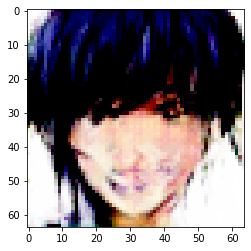

In [380]:
plt.imshow(fake[0].cpu().detach().permute(1, 2, 0))

In [381]:
etas = [0.001, 0.002, 0.006, 0.008, 0.01, 0.09, 0.1, 0.9]

In [382]:
critic_fake = V_net(fake)

In [383]:
gradients = torch.autograd.grad(outputs=critic_fake, inputs=fake,
                              grad_outputs=torch.ones(critic_fake.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

In [384]:
gradients.shape

torch.Size([128, 3, 64, 64])

In [385]:
log_PATH = os.path.join(os.getcwd(), "images_fin")

In [386]:
new = []
for eta in etas:
    new.append(fake - gradients * eta)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


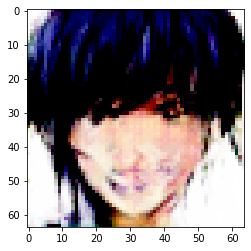

In [387]:
plt.imshow(fake[0].cpu().detach().permute(1, 2, 0))


In [355]:
transform_PIL=transforms.ToPILImage()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


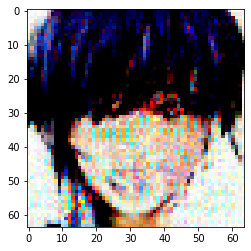

In [388]:
for i, news in enumerate(new):
    im = vutils.make_grid(torch.reshape(news[0],(3,64,64))[:64], padding=2, normalize=True)
    plt.imshow(news[0].cpu().detach().permute(1, 2, 0))
    transform_PIL(im).save(os.path.join(log_PATH,'4'+str(epoch)+'_epoh_'+str(etas[i])+"_eta_image.png"))